# Capstone Project - Moscow City Business Recommendation Metrics
### Applied Data Science Capstone by IBM

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data acquisition and cleaning](#data)
* [Methodology and clustering](#methodology)
* [Analysis](#analysis)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal group of subway station's to open shop nearby. Specifically, this report will be targeted to stakeholders interested in opening a **Pub chain** in **Moscow**, Russia.

Since there are lots of pubs in Moscow we will try to detect **locations that are not already crowded with pubs**. We are also  interested in **areas with high passenger flow and acceptable rent cost**. We would also prefer locations **as close to city center as possible**. In addition we will perform our analysis with *k-means* ML algorithm clustering so we can easily flex with requirements, and find any appropriate location according to stakeholders wishes.

We will use our data science powers to generate a few most promising subway stations based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data acquisition and cleaning <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing pubs and bars nearby the station
* passenger flow
* rent cost (price for meter squared)
* distance of the station from city center

Following data sources will be needed to extract/generate the required information:
* information about passenger flow, stations coordinates are scraped from https://mosmetro.ru/ and stored into corresponding csv files PassengerFlow.csv and StationCoords.csv. As well as rent cost stored into CostPerMSQ.csv file.
* number of pubs/bars and their type and location near every station will be obtained using **Foursquare API**

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy import distance #for distance estimating

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


 Great! Now let's download our csv files and clean them up. Let's take a first look at our initial data.

In [5]:
df_coords = pd.read_csv(r'StationCoords.csv')
df_flow = pd.read_csv(r'PassengerFlow.csv')
df_rent = pd.read_csv(r'CostPerMSQ.csv')

print(df_coords.head())
print(df_flow.head())
print(df_rent.head())

          Line LineColor               Name   Latitude  Longitude  Order
0  Калининская    FFCD1C         Новокосино  55.745113  37.864052      0
1  Калининская    FFCD1C        Новогиреево  55.752237  37.814587      1
2  Калининская    FFCD1C             Перово  55.750980  37.784220      2
3  Калининская    FFCD1C  Шоссе энтузиастов  55.758090  37.751703      3
4  Калининская    FFCD1C       Авиамоторная  55.751933  37.717444      4
             Station PassengerFlow
0          Арбатская          59,5
1         Бауманская          65,6
2       Измайловская          40,3
3  Измайловский парк          55,9
4           Киевская          57,3
        Station PriceMSQ
0   Дмитровская   43 637
1  Алексеевская   41 954
2       Рижская   45 555
3    Войковская   41 678
4  Юго-Западная   42 526


We are interested in the following rows: Station name ('Station'), geospatial coordinates ('Latitude', 'Longitude'), Passenger Flow ('PassFlow') and rent price for meter squared ('PriceMSQ')

In [6]:
df_coords = df_coords [['Name','Latitude','Longitude']]
df_coords.rename(columns={'Name': 'Station'}, inplace=True)

df_flow.columns = ['Station','PassFlow']

print(df_coords.head())
print(df_flow.head())
print(df_rent.head())

             Station   Latitude  Longitude
0         Новокосино  55.745113  37.864052
1        Новогиреево  55.752237  37.814587
2             Перово  55.750980  37.784220
3  Шоссе энтузиастов  55.758090  37.751703
4       Авиамоторная  55.751933  37.717444
             Station PassFlow
0          Арбатская     59,5
1         Бауманская     65,6
2       Измайловская     40,3
3  Измайловский парк     55,9
4           Киевская     57,3
        Station PriceMSQ
0   Дмитровская   43 637
1  Алексеевская   41 954
2       Рижская   45 555
3    Войковская   41 678
4  Юго-Западная   42 526


Now as data downloaded let us combine it into one table and convert all Passenger flow and rent cost to float type. Also some interchange stations in Moscow metro have the same names but belong to different lines. We will treat them like one station. 

In [7]:
# combining
dfs = [df_coords, df_flow, df_rent]
dfs = [df.set_index('Station') for df in dfs]
df = dfs[0].join(dfs[1:])

# dropping duplicates
df = df.reset_index()
df = df.drop_duplicates(['Station'])

# converting the types
print(df.dtypes)
df['PassFlow'] = df['PassFlow'].str.replace(',','.')
df['PriceMSQ'] = df['PriceMSQ'].str.replace(' ','')
df['PassFlow'] = pd.to_numeric(df['PassFlow'], errors='ignore')
df['PriceMSQ'] = pd.to_numeric(df['PriceMSQ'], errors='ignore')
print(df.dtypes)

df.head()
print(df.shape)

Station       object
Latitude     float64
Longitude    float64
PassFlow      object
PriceMSQ      object
dtype: object
Station       object
Latitude     float64
Longitude    float64
PassFlow     float64
PriceMSQ     float64
dtype: object
(214, 5)


Now let's seek for some missing values.

In [8]:
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Station
False    214
Name: Station, dtype: int64

Latitude
False    214
Name: Latitude, dtype: int64

Longitude
False    214
Name: Longitude, dtype: int64

PassFlow
False    139
True      75
Name: PassFlow, dtype: int64

PriceMSQ
False    125
True      89
Name: PriceMSQ, dtype: int64



We can see we have to deal with missing data for some stations. Passenger flow and price for square meter are numeric values and we can easily replace them with mean values within city.

In [9]:
avg_PassFlow = df["PassFlow"].astype("float").mean(axis=0)
print("Average of Passenger Flow:", avg_PassFlow)
avg_PriceMSQ = df["PriceMSQ"].astype("float").mean(axis=0)
print("Average of rent cost:", avg_PriceMSQ)

#replacing NaN's with mean values
df['PassFlow'].replace(np.nan, avg_PassFlow, inplace=True)
df['PriceMSQ'].replace(np.nan, avg_PriceMSQ, inplace=True)

missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Average of Passenger Flow: 59.81007194244606
Average of rent cost: 36871.024
Station
False    214
Name: Station, dtype: int64

Latitude
False    214
Name: Latitude, dtype: int64

Longitude
False    214
Name: Longitude, dtype: int64

PassFlow
False    214
Name: PassFlow, dtype: int64

PriceMSQ
False    214
Name: PriceMSQ, dtype: int64



In [10]:
print(df.shape)  
df.head()

(214, 5)


,Station,Latitude,Longitude,PassFlow,PriceMSQ
0,Авиамоторная,55.751933,37.717444,58.7,36871.024
1,Автозаводская,55.706634,37.657008,60.7,36871.024
3,Академическая,55.687147,37.572300,62.0,40529.000
4,Александровский сад,55.752255,37.608775,38.2,36871.024
5,Алексеевская,55.807794,37.638699,65.4,41954.000


As we finished with initial assembling we calculate the distance between station and city center with GeoPy module and add it to our table.

In [11]:
df.reset_index(drop = True, inplace = True)

#coordinates of Moscow city centre
moscow = (55.753960, 37.620393)

for i, row in df.iterrows():
    station = (row['Latitude'], row['Longitude'])
    df.loc[i, 'Distance'] = distance.distance(moscow, station).km

print(df.shape) 
df.head()

(214, 6)


,Station,Latitude,Longitude,PassFlow,PriceMSQ,Distance
0,Авиамоторная,55.751933,37.717444,58.7,36871.024,6.098029
1,Автозаводская,55.706634,37.657008,60.7,36871.024,5.749396
2,Академическая,55.687147,37.572300,62.0,40529.000,8.029258
3,Александровский сад,55.752255,37.608775,38.2,36871.024,0.753788
4,Алексеевская,55.807794,37.638699,65.4,41954.000,6.102827


### Foursquare
#### Use Foursquare API to get info on pubs and bars in each location.

We're interested in venues in 'food' category, but only those that are similar to our Pub - Bars, Night Clubs and etc. We will count similar venues nearby every station and add "Count" column into our table. At first let's Define Foursquare Credentials and Version, write request and convert data from the initial format to a format that may be better for analysis.

In [12]:
CLIENT_ID = '1O02SD1F2HAJRVYRKQO4UW015NW1LMDVSSJO05AN2TYIWW5G' # your Foursquare ID
CLIENT_SECRET = 'W53DIFCQQTQC25ARASXAUC4YIRNJ5YTFSBWJX3SRGODBPU1D' # your Foursquare Secret
VERSION = '20180323'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1O02SD1F2HAJRVYRKQO4UW015NW1LMDVSSJO05AN2TYIWW5G
CLIENT_SECRET:W53DIFCQQTQC25ARASXAUC4YIRNJ5YTFSBWJX3SRGODBPU1D


Test request on a single station and get the top 100 venues that are within a radius of 700m.

In [13]:
station_latitude = df.loc[66, 'Latitude'] # station latitude value
station_longitude = df.loc[66, 'Longitude'] # station longitude value
station_name = df.loc[66, 'Station'] # station name

print('Latitude and longitude values of {} are {}, {}.'.format(station_name, 
                                                               station_latitude, 
                                                               station_longitude))

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 700 # Define radius

# create request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    station_latitude, 
    station_longitude, 
    radius, 
    LIMIT)

url # display URL

Latitude and longitude values of Комсомольская are 55.774072, 37.654565000000005.


'https://api.foursquare.com/v2/venues/explore?&client_id=1O02SD1F2HAJRVYRKQO4UW015NW1LMDVSSJO05AN2TYIWW5G&client_secret=W53DIFCQQTQC25ARASXAUC4YIRNJ5YTFSBWJX3SRGODBPU1D&v=20180323&ll=55.774072,37.654565000000005&radius=700&limit=100'

 We are ready to send request, clean the json answer file and structure it into a *pandas* dataframe.

In [14]:
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
   
nearby_venues = json_normalize(venues) # Flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng'] # filter columns
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1) # filter the category for each row

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)
nearby_venues.head()

(52, 4)


,name,categories,lat,lng
0,Executive Lounge,Hotel Bar,55.774012,37.651353
1,Спартак Стор,Sporting Goods Shop,55.773883,37.657475
2,Kafin,Coffee Shop,55.773788,37.655388
3,Hilton,Hotel,55.774325,37.652009
4,Double B Coffee & Tea (Даблби),Coffee Shop,55.772894,37.652571


We received 52 venues returned by Foursquare. Now we are up to create a function to repeat the same process to all the stations in Moscow.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Category ID']

    return(nearby_venues)
    print('Process complete.')
# Applying the function to initial dataframe with subway stations
moscow_venues = getNearbyVenues(names=df['Station'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
print('Success')

Авиамоторная
Автозаводская
Академическая
Александровский сад
Алексеевская
Алма-Атинская
Алтуфьево
Андроновка
Аннино
Арбатская
Аэропорт
Бабушкинская
Багратионовская
Балтийская
Баррикадная
Бауманская
Беговая
Белокаменная
Белорусская
Беляево
Бибирево
Библиотека им.Ленина
Битцевский Парк
Борисово
Боровицкая
Ботанический сад
Братиславская
Бульвар Адмирала Ушакова
Бульвар Дмитрия Донского
Бульвар Рокоссовского
Бунинская аллея
Бутырская 
ВДНХ
Варшавская
Верхние Котлы
Владыкино
Водный стадион
Войковская
Волгоградский проспект
Волжская
Волоколамская
Воробьевы горы
Выставочная
Выставочный центр
Выхино
Деловой центр
Динамо
Дмитровская
Добрынинская
Домодедовская
Достоевская
Дубровка
Жулебино
ЗИЛ
Зорге
Зябликово
Измайлово
Измайловская
Калужская
Кантемировская
Каховская
Каширская
Киевская
Китай-город
Кожуховская
Коломенская
Комсомольская
Коньково
Коптево
Котельники
Красногвардейская
Краснопресненская
Красносельская
Красные ворота
Крестьянская застава
Кропоткинская
Крылатское
Крымская
Кузнецкий мост


In [16]:
print(moscow_venues.shape)
moscow_venues.head()

(10864, 8)


,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID
0,Авиамоторная,55.751933,37.717444,Virtuality Club,55.754683,37.718865,Arcade,4bf58dd8d48988d1e1931735
1,Авиамоторная,55.751933,37.717444,Факел,55.751531,37.716282,Movie Theater,4bf58dd8d48988d17f941735
2,Авиамоторная,55.751933,37.717444,Рубикон Батут,55.747969,37.717109,Gym / Fitness Center,4bf58dd8d48988d175941735
3,Авиамоторная,55.751933,37.717444,ВкусВилл,55.752324,37.716605,Health Food Store,50aa9e744b90af0d42d5de0e
4,Авиамоторная,55.751933,37.717444,Золотой дракон,55.751687,37.712340,Martial Arts Dojo,4bf58dd8d48988d101941735


The request delivered us 10864 venues. As our stakeholder assumes to open a pub chain, we filter those venues with an id_list of similar categories such as Bar, Pub, Hotel bar etc.

In [17]:
id_list = ['52e81612bcbc57f1066b7a06', '4bf58dd8d48988d116941735', '56aa371ce4b08b9a8d57356c',
           '4bf58dd8d48988d11e941735', '4bf58dd8d48988d11b941735', '4bf58dd8d48988d123941735',
           '4bf58dd8d48988d121941735', '4bf58dd8d48988d11f941735', '52f2ae52bcbc57f1066b8b81',
           '4bf58dd8d48988d1d5941735']

df_venue_count = moscow_venues['Category ID'].isin(id_list)
df_venue_count.describe()

count     10864
unique        2
top       False
freq      10386
Name: Category ID, dtype: object

In [18]:
# inverting to float64 type
df_venue_count = df_venue_count.replace(True, 1)
df_venue_count = df_venue_count.rename('Count')
df_venue_count.dtypes

dtype('float64')

In [19]:
# concatenation, grouping and dropping excess columns
df_count = pd.concat([moscow_venues, df_venue_count], axis=1)
df_count = df_count.groupby('Station').sum()
df_count = df_count.drop(df_count.columns[[0,1,2,3]], axis=1)
print(df_count.shape)
df_count.head()

(214, 1)


,Count
Station,
Авиамоторная,1.0
Автозаводская,3.0
Академическая,3.0
Александровский сад,9.0
Алексеевская,1.0


In [20]:
df = df.set_index('Station')
df.head()

,Latitude,Longitude,PassFlow,PriceMSQ,Distance
Station,,,,,
Авиамоторная,55.751933,37.717444,58.7,36871.024,6.098029
Автозаводская,55.706634,37.657008,60.7,36871.024,5.749396
Академическая,55.687147,37.572300,62.0,40529.000,8.029258
Александровский сад,55.752255,37.608775,38.2,36871.024,0.753788
Алексеевская,55.807794,37.638699,65.4,41954.000,6.102827


Concatenating two dataframes into resulting one.

In [21]:
result_df = df.join(df_count)
print(result_df.shape)
result_df.head()

(214, 6)


,Latitude,Longitude,PassFlow,PriceMSQ,Distance,Count
Station,,,,,,
Авиамоторная,55.751933,37.717444,58.7,36871.024,6.098029,1.0
Автозаводская,55.706634,37.657008,60.7,36871.024,5.749396,3.0
Академическая,55.687147,37.572300,62.0,40529.000,8.029258,3.0
Александровский сад,55.752255,37.608775,38.2,36871.024,0.753788,9.0
Алексеевская,55.807794,37.638699,65.4,41954.000,6.102827,1.0


#### Easy to notice that our values are not in a similar range and inconvenient to analyze. We will normalize them.
Normalization is the process of transforming values of several variables into a similar range. Typical normalizations include scaling the variable so the variable average is 0, scaling the variable so the variance is 1, or scaling variable so the variable values range from 0 to 1.

In [22]:
result_df['PassFlow'] = result_df['PassFlow']/result_df['PassFlow'].max()
result_df['PriceMSQ'] = result_df['PriceMSQ']/result_df['PriceMSQ'].max()
result_df['Distance'] = result_df['Distance']/result_df['Distance'].max()
result_df['Count'] = result_df['Count']/result_df['Count'].max()
result_df.head()

,Latitude,Longitude,PassFlow,PriceMSQ,Distance,Count
Station,,,,,,
Авиамоторная,55.751933,37.717444,0.313736,0.553104,0.244603,0.066667
Автозаводская,55.706634,37.657008,0.324425,0.553104,0.230619,0.200000
Академическая,55.687147,37.572300,0.331374,0.607978,0.322068,0.200000
Александровский сад,55.752255,37.608775,0.204169,0.553104,0.030236,0.600000
Алексеевская,55.807794,37.638699,0.349546,0.629354,0.244795,0.066667


Since we interpret 1 as 'good' and 0 as 'bad' we need to reverse the values in  the following rows 'PriceMSQ', 'Count' and 'Distance' (as we need them to be low for being 'good') except passenger flow, it is good as it grows up.

In [23]:
result_df['PriceMSQ'] = 1 - result_df['PriceMSQ']
result_df['Count'] = 1 - result_df['Count']
result_df['Distance'] = 1 - result_df['Distance']

result_df.head()

,Latitude,Longitude,PassFlow,PriceMSQ,Distance,Count
Station,,,,,,
Авиамоторная,55.751933,37.717444,0.313736,0.446896,0.755397,0.933333
Автозаводская,55.706634,37.657008,0.324425,0.446896,0.769381,0.800000
Академическая,55.687147,37.572300,0.331374,0.392022,0.677932,0.800000
Александровский сад,55.752255,37.608775,0.204169,0.446896,0.969764,0.400000
Алексеевская,55.807794,37.638699,0.349546,0.370646,0.755205,0.933333


## Methodology and clustering <a name="methodology"></a>

At this stage we will use the *k*-means clustering algorithm to perform our analysis. Algorithm will partition our locations into five groups since we specified the algorithm to generate 5 clusters. The stations in each cluster are similar to each other in terms of the features included in the dataset. We will use the Folium library to visualize the stations in Moscow and their emerging clusters to become acquainted with clusters. After that, we will observe and wrangle data to search the most suitable station, according to stakeholder's requirements.

In [24]:
# dropping irrelevent coordinate rows
result_df_clus = result_df.drop(result_df.columns[[0,1]], axis=1)

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=7).fit(result_df_clus)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 1, 0, 1, 3, 3, 1, 3, 0], dtype=int32)

In [25]:
lat = 55.753960
long = 37.620393

# add clustering labels
result_df.insert(0, 'Cluster Labels', kmeans.labels_)

result_df[["Cluster Labels"]] = result_df[["Cluster Labels"]].astype("int")
result_df.reset_index(inplace=True)
result_df.head()

,Station,Cluster Labels,Latitude,Longitude,PassFlow,PriceMSQ,Distance,Count
0,Авиамоторная,1,55.751933,37.717444,0.313736,0.446896,0.755397,0.933333
1,Автозаводская,4,55.706634,37.657008,0.324425,0.446896,0.769381,0.800000
2,Академическая,1,55.687147,37.572300,0.331374,0.392022,0.677932,0.800000
3,Александровский сад,0,55.752255,37.608775,0.204169,0.446896,0.969764,0.400000
4,Алексеевская,1,55.807794,37.638699,0.349546,0.370646,0.755205,0.933333


In [26]:
lat = 55.753960
long = 37.620393
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result_df['Latitude'], result_df['Longitude'], result_df['Station'], result_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analysis <a name="analysis"></a>

Now we can create a profile for each group, considering the common characteristics of each cluster. Instead of observing clusters directly, we will try to get some insights using *describe* method. Since we are dealing with 0, 1 interval where 1 means high quality sample and 0 low quality respectively, we are able to estimate summary assessment by *mean* values each feature and sum them up. Eventually we will receive final metric, which represents quality of cluster overall.

In [27]:
# straight observe is not very convenient
result_df.loc[result_df['Cluster Labels'] == 0, result_df.columns[[0,1,4,5,6,7]]].head()

,Station,Cluster Labels,PassFlow,PriceMSQ,Distance,Count
3,Александровский сад,0,0.204169,0.446896,0.969764,0.400000
9,Арбатская,0,0.318012,0.446896,0.956796,0.333333
18,Белорусская,0,0.313736,0.446896,0.857567,0.400000
63,Китай-город,0,0.274185,0.446896,0.970224,0.333333
75,Кропоткинская,0,0.220203,0.446896,0.943813,0.400000


We can form an easy-to-read plate of average characteristics of each cluster.

In [28]:
def GetMetrics(result_df, col, i):
    return result_df.loc[result_df['Cluster Labels'] == i, result_df.columns[[0,1,4,5,6,7]]].describe()[col][1]

column_names = ['PassFlow', 'PriceMSQ', 'Distance', 'Count']
clusters = [0,1,2,3,4]
mean_cluster_metrics = pd.DataFrame(columns = column_names, index=[0,1,2,3,4])

for i in clusters:
    for col in column_names:
        mean_cluster_metrics[col][i] = GetMetrics(result_df, col, i)
        
mean_cluster_metrics

,PassFlow,PriceMSQ,Distance,Count
0,0.305793,0.420528,0.936962,0.266667
1,0.286736,0.447007,0.650296,0.961686
2,0.635103,0.47031,0.551884,0.951852
3,0.334457,0.52632,0.304996,0.966667
4,0.244808,0.367865,0.845246,0.777778


 Now we can summarize mean values and visualize it with area plot to visibly estimate clusters.

In [29]:
col_list = list(mean_cluster_metrics)
sum_cluster_metrics = mean_cluster_metrics[col_list].sum(axis=1)
sum_cluster_metrics.head()

0    1.929950
1    2.345725
2    2.609148
3    2.132440
4    2.235697
dtype: float64

Text(0.5, 0, 'Clusters')

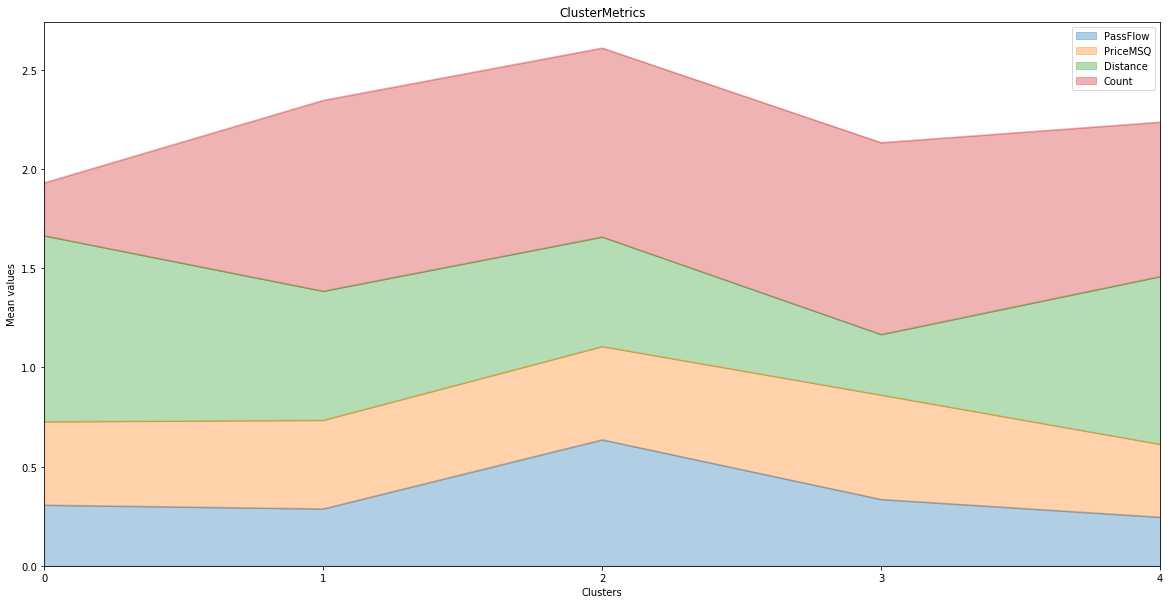

In [30]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

ax = mean_cluster_metrics.plot(xticks=[0,1,2,3,4], kind='area', alpha=0.35, figsize=(20, 10))

ax.set_title('ClusterMetrics')
ax.set_ylabel('Mean values')
ax.set_xlabel('Clusters')

Great! It is easy to notice some patterns in cluster's values and their locations on the map. For example, cluster's 0 obvious feature is 'Distance' value, the stations from this cluster are surrounding the center of the city, but they have very poor values of 'Count' as they have lots of Pub and Bars around them. Cluster 4 has very prominent results, as it has very good 'Distance' and 'Count' values but 'Passenger Flow' it quite bad. 

Cluster 2 has the highest mean values summarized. It also has the highest values of 'Count', 'Passenger Flow' and worthy values of 'Distance' and 'PriceMSQ'. So we would strongly recommend our stakeholder to pick locations from this cluster. 

In [31]:
result_cluster = result_df.loc[result_df['Cluster Labels'] == 2, result_df.columns[[0,1,4,5,6,7]]]
result_cluster

,Station,Cluster Labels,PassFlow,PriceMSQ,Distance,Count
11,Бабушкинская,2,0.471940,0.524707,0.467313,1.000000
32,ВДНХ,2,0.715660,0.404593,0.702297,0.800000
37,Войковская,2,0.498129,0.374786,0.576493,1.000000
44,Выхино,2,0.943880,0.564970,0.476871,1.000000
65,Коломенская,2,0.523250,0.451232,0.641165,1.000000
66,Комсомольская,2,1.000000,0.238607,0.875619,0.866667
79,Кузьминки,2,0.619989,0.519786,0.579828,0.933333
105,Новогиреево,2,0.609300,0.544118,0.510839,1.000000
116,Отрадное,2,0.492250,0.523057,0.505839,0.933333
125,Петровско-Разумовская,2,0.620524,0.501950,0.614195,1.000000


The final step is to determine the top 10 stations in the cluster.

In [32]:
col_list = list (result_cluster)
col_list.remove('Cluster Labels')
result_cluster['Total'] = result_cluster[col_list].sum(axis = 1)
result_cluster.nlargest(10, 'Total')

,Station,Cluster Labels,PassFlow,PriceMSQ,Distance,Count,Total
44,Выхино,2,0.943880,0.564970,0.476871,1.000000,2.985721
66,Комсомольская,2,1.000000,0.238607,0.875619,0.866667,2.980892
170,Текстильщики,2,0.634955,0.490114,0.654738,1.000000,2.779807
125,Петровско-Разумовская,2,0.620524,0.501950,0.614195,1.000000,2.736669
105,Новогиреево,2,0.609300,0.544118,0.510839,1.000000,2.664257
79,Кузьминки,2,0.619989,0.519786,0.579828,0.933333,2.652937
198,Черкизовская,2,0.506146,0.507306,0.618293,1.000000,2.631745
208,Щелковская,2,0.663816,0.542543,0.487221,0.933333,2.626914
32,ВДНХ,2,0.715660,0.404593,0.702297,0.800000,2.622550
65,Коломенская,2,0.523250,0.451232,0.641165,1.000000,2.615646


At last, we received 10 possibly best stations for opening pub nearby, each of them has its pros and cons. 'Комсомольская' Station has the best 'Passenger Flow' and 'Distance' values, but it has very high rent cost. 'Выхино' is one with the best rent cost and 'Текстильщики' is middle way between these two. Accordning to stakeholders specific requirements we can choose the most appropriate one.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Moscow subway stations close to center with low number of pubs and bars nearby, high passenger flow and low commercial rent cost, in order to aid stakeholders in narrowing down the search for optimal location for a pub chain. With initial scrapped data about rent, passenger flow, calculated distance between stations and city center, also pubs distribution from Foursquare we have identified general cluster that satisfy our analysis. In fine we obtain the final exploration about the appropriate stations to open pub nearby according to stakeholder requirements. 